In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 6)
import numpy as np
import librosa, librosa.display, IPython.display as ipd
from tqdm import tqdm
import glob
import pandas as pd
import h5py
from sklearn import preprocessing
import pickle
import random as rn
np.random.seed(1515)
rn.seed(1254)

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
from tensorflow import set_random_seed
set_random_seed(2)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config) 
    
import keras 
from keras.backend.tensorflow_backend import set_session
set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D, LSTM, GRU, Bidirectional
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
#SET PATHS
dataspace = '/vol/vssp/datasets/audio01/UrbanSound8K/audio/'
projectspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'

metadatafile = '/vol/vssp/datasets/audio01/UrbanSound8K/metadata/UrbanSound8K.csv'
metadata = pd.read_csv(metadatafile)

hdf5_path = os.path.join(projectspace,'dataset.hdf5') 
modelfolder = os.path.join(projectspace,'models')
scalerpath = os.path.join(projectspace,'scaler.pkl')

In [4]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))0.67
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [5]:
# SCALE THE DATA
scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]


In [6]:
len(y_val)

816

In [16]:
def build_rnn(n_frames=n_frames, n_features=n_features,
                     n_classes=10):

    # INPUT
    x = Input(shape=(n_frames, n_features), dtype='float32')
  
    y= LSTM(120, return_sequences = True)(x)
    y= Dropout(0.2)(y)  
    
    y= LSTM(120)(y)
    y= Dropout(0.2)(y) 

    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [17]:
m = build_rnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 173, 40)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 173, 120)          77280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 173, 120)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1210      
Total params: 194,170
Trainable params: 194,170
Non-trainable params: 0
_________________________________________________________________


In [18]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model_checkpoint = ModelCheckpoint(
    os.path.join(modelfolder, 'rnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
    monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

history = m.fit(x=np.array(X_train_scaled), y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_data=(np.array(X_val_scaled), y_val), shuffle=True)

Train on 7079 samples, validate on 816 samples
Epoch 1/200
7079/7079 [==============================] - 26s 4ms/step - loss: 1.8588 - acc: 0.3317 - val_loss: 1.6259 - val_acc: 0.3174
Epoch 2/200
7079/7079 [==============================] - 26s 4ms/step - loss: 1.5591 - acc: 0.4121 - val_loss: 1.5971 - val_acc: 0.3480
Epoch 3/200
7079/7079 [==============================] - 26s 4ms/step - loss: 1.4992 - acc: 0.4349 - val_loss: 1.5143 - val_acc: 0.3640
Epoch 4/200
7079/7079 [==============================] - 26s 4ms/step - loss: 1.4554 - acc: 0.4412 - val_loss: 1.6578 - val_acc: 0.3995
Epoch 5/200
7079/7079 [==============================] - 26s 4ms/step - loss: 1.3747 - acc: 0.4871 - val_loss: 1.6435 - val_acc: 0.4069
Epoch 6/200
7079/7079 [==============================] - 26s 4ms/step - loss: 1.3887 - acc: 0.4847 - val_loss: 1.6253 - val_acc: 0.3799
Epoch 7/200
7079/7079 [==============================] - 26s 4ms/step - loss: 1.3851 - acc: 0.4645 - val_loss: 1.5170 - val_acc: 0.5123
E

7079/7079 [==============================] - 26s 4ms/step - loss: 0.4869 - acc: 0.8438 - val_loss: 1.4913 - val_acc: 0.6103
Epoch 61/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.4864 - acc: 0.8462 - val_loss: 1.5027 - val_acc: 0.5821
Epoch 62/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.7906 - acc: 0.7401 - val_loss: 1.4937 - val_acc: 0.5858
Epoch 63/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.7229 - acc: 0.7553 - val_loss: 1.5124 - val_acc: 0.6042
Epoch 64/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.5596 - acc: 0.8185 - val_loss: 1.5726 - val_acc: 0.5760
Epoch 65/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.5809 - acc: 0.8127 - val_loss: 1.5799 - val_acc: 0.5674
Epoch 66/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.5131 - acc: 0.8380 - val_loss: 1.6951 - val_acc: 0.5833
Epoch 67/200
7079/7079 [==============================

Epoch 120/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.2099 - acc: 0.9349 - val_loss: 2.0037 - val_acc: 0.6238
Epoch 121/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.1775 - acc: 0.9415 - val_loss: 1.8778 - val_acc: 0.6336
Epoch 122/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.1468 - acc: 0.9549 - val_loss: 1.9817 - val_acc: 0.6360
Epoch 123/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.1336 - acc: 0.9607 - val_loss: 1.9279 - val_acc: 0.6311
Epoch 124/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.0915 - acc: 0.9719 - val_loss: 2.0536 - val_acc: 0.6311
Epoch 125/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.0723 - acc: 0.9784 - val_loss: 2.4990 - val_acc: 0.5833
Epoch 126/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.1101 - acc: 0.9660 - val_loss: 2.3282 - val_acc: 0.5613
Epoch 127/200
7079/7079 [=========

7079/7079 [==============================] - 26s 4ms/step - loss: 0.0431 - acc: 0.9879 - val_loss: 2.7036 - val_acc: 0.6127
Epoch 180/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.0283 - acc: 0.9922 - val_loss: 2.8017 - val_acc: 0.6250
Epoch 181/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.0957 - acc: 0.9722 - val_loss: 2.8397 - val_acc: 0.5797
Epoch 182/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.1708 - acc: 0.9500 - val_loss: 2.3879 - val_acc: 0.6029
Epoch 183/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.1732 - acc: 0.9506 - val_loss: 2.4316 - val_acc: 0.6164
Epoch 184/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.0973 - acc: 0.9705 - val_loss: 2.3233 - val_acc: 0.6176
Epoch 185/200
7079/7079 [==============================] - 26s 4ms/step - loss: 0.0497 - acc: 0.9856 - val_loss: 2.5027 - val_acc: 0.6042
Epoch 186/200
7079/7079 [=======================

In [20]:
prediction = m.predict(np.array(X_test_scaled), batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 1s 868us/step


Accuracy: 0.57


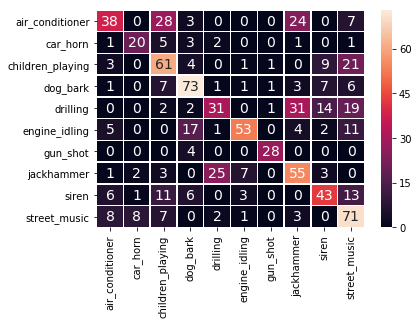

In [21]:
from sklearn.metrics import confusion_matrix

acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, yticklabels=label_list,xticklabels=label_list)